# Final Summary Notebook

In [3]:
# Initialise a spark session
import pandas as pd
from collections import Counter
import os
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.ml.regression import RandomForestRegressionModel, GBTRegressionModel
from scipy.stats import spearmanr

spark = (
    SparkSession.builder.appName("Final Summary")
    .config("spark.sql.repl.eagerEval.enabled", True)
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.driver.memory", "8g")  
    .config("spark.executor.memory", "8g") 
    .config("spark.executor.instances", "4")  
    .config("spark.driver.maxResultSize", "2g")
    .config("spark.sql.shuffle.partitions", "200") \
    .getOrCreate()
)

In [13]:
rf_model = RandomForestRegressionModel.load("../models/random_forest_model")
gbt_model = GBTRegressionModel.load("../models/gbt_model")

## Comparing Models Feature Importance

In [14]:
rf_importances = rf_model.featureImportances
rf_importance_values = rf_importances.toArray()

In [18]:
# Adjust feature columns to account for expanded features
final_df = spark.read.parquet('../data/curated/final_df.parquet/')


# Assuming you have the following feature columns before encoding and scaling
original_feature_cols = [
    'monthly_revenue', 'transaction_count', 'avg_fraud_probability_merchant', 'avg_unemployment_rate',
    'state_consumer_encoded', 'gender_consumer_encoded', 'revenue_growth', 'category_encoded', 'revenue_band_encoded',
    'avg_take_rate'
]

# Determine the size of each OneHotEncoded column
encoded_sizes = {
    'state_consumer_encoded': 7,  # Example, adjust based on your data
    'gender_consumer_encoded': 3,
    'category_encoded': 25,
    'revenue_band_encoded': 5
}

# Manually expand the encoded feature columns
expanded_feature_names = []

for col in original_feature_cols:
    if col in encoded_sizes:
        # For OneHotEncoded features, append the individual components
        expanded_feature_names += [f"{col}_{i}" for i in range(encoded_sizes[col])]
    else:
        # For regular numeric features, just append the column name
        expanded_feature_names.append(col)


# Extract feature importances for Random Forest
rf_importances = rf_model.featureImportances.toArray()

# Extract feature importances for GBT
gbt_importances = gbt_model.featureImportances.toArray()

# Create DataFrame for Random Forest feature importance
rf_feature_importance_df = pd.DataFrame({
    'Feature': expanded_feature_names[:len(rf_importances)],  # Ensure the feature list matches importance values
    'Importance': rf_importances
}).sort_values(by='Importance', ascending=False).head(10)  # Select top 10 important features

# Create DataFrame for GBT feature importance
gbt_feature_importance_df = pd.DataFrame({
    'Feature': expanded_feature_names[:len(gbt_importances)],  # Ensure the feature list matches importance values
    'Importance': gbt_importances
}).sort_values(by='Importance', ascending=False).head(10)  # Select top 10 important features


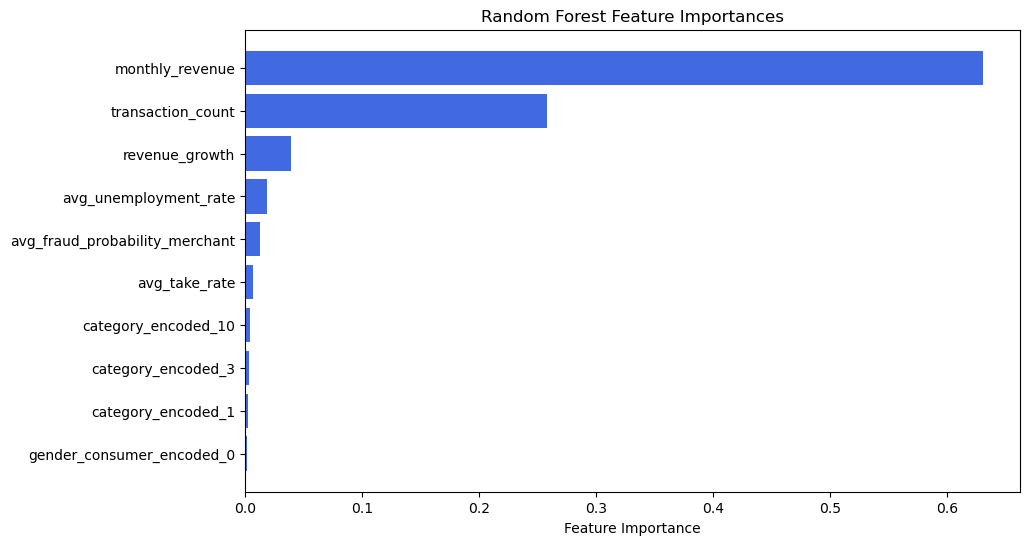

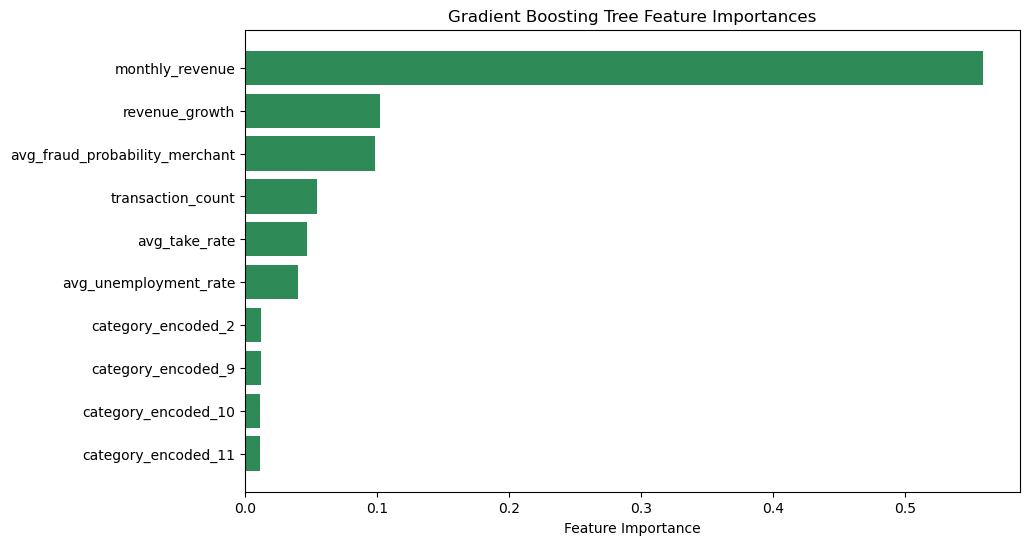

In [19]:
import matplotlib.pyplot as plt

# Random Forest
plt.figure(figsize=(10, 6))
plt.barh(rf_feature_importance_df['Feature'], rf_feature_importance_df['Importance'], color='royalblue')
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importances')
plt.gca().invert_yaxis()  # To have the highest importance on top
plt.show()

# GBT
plt.figure(figsize=(10, 6))
plt.barh(gbt_feature_importance_df['Feature'], gbt_feature_importance_df['Importance'], color='seagreen')
plt.xlabel('Feature Importance')
plt.title('Gradient Boosting Tree Feature Importances')
plt.gca().invert_yaxis()  # To have the highest importance on top
plt.show()

The encoded categories referred to are:

For Random Forest Model:
* Category for category_encoded_10: furniture, home furnishings and equipment shops, and manufacturers, except appliances
* Category for category_encoded_3: computer programming , data processing, and integrated systems design services
* Category for category_encoded_1: digital goods: books, movies, music
* Category for category_encoded_0: tent and awning shops

For GBT Model:
* Category for category_encoded_2: computer programming , data processing, and integrated systems design services
* Category for category_encoded_9: watch, clock, and jewelry repair shops
* Category for category_encoded_10: furniture, home furnishings and equipment shops, and manufacturers, except appliances
* Category for category_encoded_11: books, periodicals, and newspapers

In both models, the category of computer programming and furniture segments are in the top 10 important features, meaning that being in these industries likely would have a bigger impact on projected monthly revenue.

## Evaluating Frauds in Categories
There are a significant amount of transactions flagged as fraud in the tent segment.

In [20]:
transactions = spark.read.parquet('../data/curated/flagged_fraud')

/var/folders/nb/ptvngvk147s5wfkvdykjdlvm0000gn/T/ipykernel_12753/2777900153.py:9: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()  # Adjust layout to prevent clipping of labels


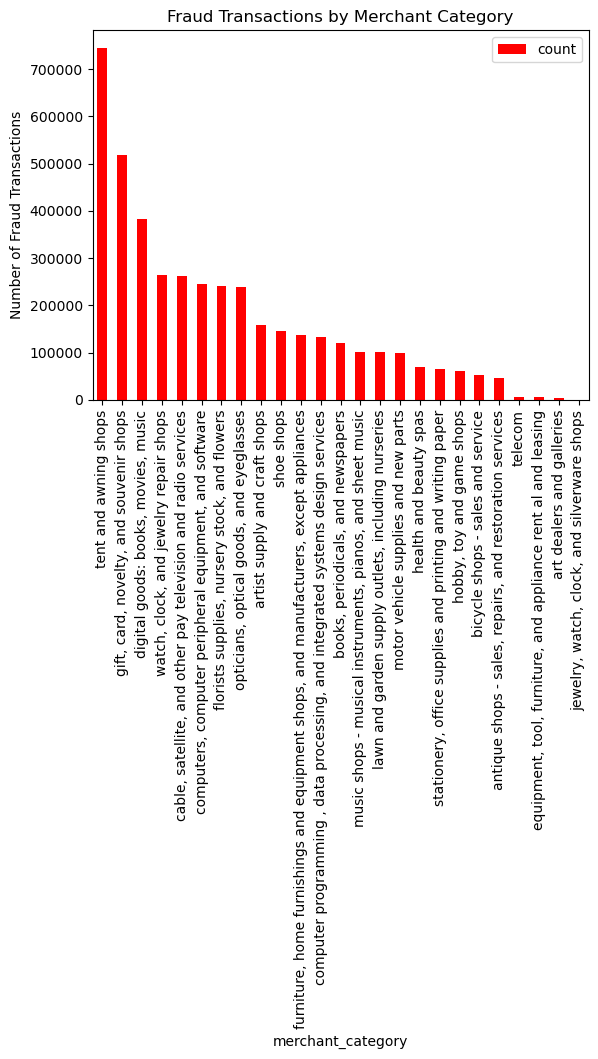

In [21]:
# Fraud transactions by merchant category
fraud_category = transactions.filter("is_fraud == true").groupBy("merchant_category").count()
fraud_category_df = fraud_category.orderBy(F.desc("count")).toPandas()

fraud_category_df.plot(kind='bar', x='merchant_category', y='count', color='red')
plt.title("Fraud Transactions by Merchant Category")
plt.ylabel("Number of Fraud Transactions")
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

# Close the previous plot to avoid any overlap
plt.close()

## Distinct Fraud Probability Distributions between Consumer and Merchants

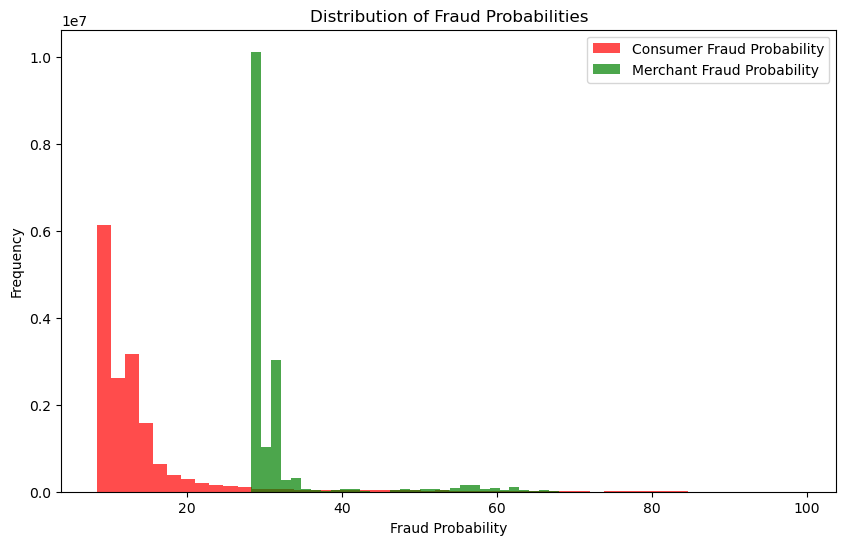

In [23]:
df_pandas_fraud_prob = transactions.select("fraud_probability_consumer", "fraud_probability_merchant").toPandas()

plt.figure(figsize=(10,6))
plt.hist(df_pandas_fraud_prob['fraud_probability_consumer'], bins=50, color='red', alpha=0.7, label="Consumer Fraud Probability")
plt.hist(df_pandas_fraud_prob['fraud_probability_merchant'], bins=50, color='green', alpha=0.7, label="Merchant Fraud Probability")
plt.xlabel('Fraud Probability')
plt.ylabel('Frequency')
plt.title('Distribution of Fraud Probabilities')
plt.legend()
plt.show()


## Comparing Overall Top 100 Merchant Rankings (Random Forest vs. GBT Model)

In [17]:
RF_ranking = spark.read.parquet('../data/curated/RF_ranking')
GBT_ranking = spark.read.parquet('../data/curated/GBT_ranking')

### Spearman's Rank Correlation
Measures the degree of similarity between the two rankings. Higher values close to 1 indicate that the rankings are similar.

In [18]:
# Perform the inner join
prediction_comparison = RF_ranking.alias("rf").join(
    GBT_ranking.alias("gbt"),
    on="merchant_abn",
    how="inner"
).select(
    F.col("merchant_abn"),
    F.col("rf.projected_revenue").alias("RF_rank"),
    F.col("gbt.projected_revenue").alias("GBT_rank")
)

predictions_pandas = prediction_comparison.toPandas()
spearman_corr, p_value = spearmanr(predictions_pandas['RF_rank'], predictions_pandas['GBT_rank'])

print(f"Spearman Rank Correlation: {spearman_corr}")


Spearman Rank Correlation: 0.8287428808691683


In [19]:
RF_ranking.printSchema()

root
 |-- merchant_abn: long (nullable = true)
 |-- merchant_name: string (nullable = true)
 |-- merchant_category: string (nullable = true)
 |-- future_order_month_year: string (nullable = true)
 |-- projected_revenue: double (nullable = true)
 |-- RF_rank: integer (nullable = true)



In [20]:
# Perform the inner join
ranking_comparison = RF_ranking.alias("rf").join(
    GBT_ranking.alias("gbt"),
    on="merchant_abn",
    how="inner"
).select(
    F.col("merchant_abn"),
    F.col("RF_rank"),
    F.col("GBT_rank")
)

ranking_pandas = ranking_comparison.toPandas()
spearman_corr, p_value = spearmanr(ranking_pandas['RF_rank'], ranking_pandas['GBT_rank'])

print(f"Spearman Rank Correlation: {spearman_corr}")


Spearman Rank Correlation: 0.8285077241598982


### Overlap in Top 100 Merchants

In [21]:
# Select top K merchants from each ranking
K = 100
RF_top_k = RF_ranking.orderBy(F.asc("projected_revenue")).limit(K).select("merchant_abn")
GBT_top_k = GBT_ranking.orderBy(F.asc("projected_revenue")).limit(K).select("merchant_abn")

# Find the intersection of the two sets (common merchants in the top K)
common_top_k = RF_top_k.intersect(GBT_top_k)

# Calculate the percentage of overlap
common_count = common_top_k.count()
overlap_percentage = (common_count / K) * 100

print(f"Top {K} Overlap: {common_count} merchants ({overlap_percentage:.2f}%)")

Top 100 Overlap: 91 merchants (91.00%)


### Overlap in Segmentation Top 10 Merchants and Overall Top 100 Merchants